#### Import the dependencies

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from itertools import product
from math import sqrt

#### Read the training dataset

In [58]:
df = pd.read_csv('./CE802_P3_Data/CE802_P3_Data.csv')

#### Check the amount of rows

In [3]:
len(df)

1500

#### Check missing null values

In [5]:
df.isnull().sum()

Target    0
F1        0
F2        0
F3        0
F4        0
F5        0
F6        0
F7        0
F8        0
F9        0
F10       0
F11       0
F12       0
F13       0
F14       0
F15       0
F16       0
dtype: int64

#### Check about the types of the features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  1500 non-null   float64
 1   F1      1500 non-null   float64
 2   F2      1500 non-null   float64
 3   F3      1500 non-null   float64
 4   F4      1500 non-null   float64
 5   F5      1500 non-null   float64
 6   F6      1500 non-null   float64
 7   F7      1500 non-null   float64
 8   F8      1500 non-null   object 
 9   F9      1500 non-null   int64  
 10  F10     1500 non-null   float64
 11  F11     1500 non-null   float64
 12  F12     1500 non-null   int64  
 13  F13     1500 non-null   float64
 14  F14     1500 non-null   float64
 15  F15     1500 non-null   object 
 16  F16     1500 non-null   float64
dtypes: float64(13), int64(2), object(2)
memory usage: 199.3+ KB


In [7]:
df['F8'].unique()

array(['Europe', 'Rest', 'UK', 'USA'], dtype=object)

In [8]:
df['F15'].unique()

array(['High', 'Very low', 'Very high', 'Medium', 'Low'], dtype=object)

#### Create the preprocess function

This function has the objective of preparing the current dataframe named as `df` by creating dummy variables and mapping categorical values, as well as moving the `Target` column as the first column in the df

In [47]:
def preprocess():
    global df
    df = pd.get_dummies(df, columns=['F8'])
    f15_mapping_dict = {'Very low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very high': 4}
    df['F15'] = df['F15'].map(f15_mapping_dict)
    value = df['Target']
    df = df.drop(columns=['Target'])
    df.insert(0, 'Target', value)

In [59]:
preprocess()
df.head()

,Target,F1,F2,F3,F4,F5,F6,F7,F9,F10,F11,F12,F13,F14,F15,F16,F8_Europe,F8_Rest,F8_UK,F8_USA
0,167.75,0.00,1.73,3.14,5.73,-5.48,-743.61,152.20,3,1577.82,-383.82,12,-2289.14,-19.69,3,25354.83,1,0,0,0
1,704.46,9.84,3.46,6.02,14.42,-10.94,-820.35,68.56,4,1884.69,-488.34,6,-2899.20,-19.46,0,32380.17,0,1,0,0
2,302.43,4.14,-1.95,6.96,4.27,-7.94,-818.43,107.86,4,2063.79,-287.76,6,-2885.52,-20.57,4,28882.38,0,1,0,0
3,2420.98,20.06,-3.34,3.76,4.78,-6.30,-814.53,147.04,7,1319.19,-435.54,4,-2319.80,-20.24,4,28523.04,0,0,1,0
4,271.65,63.63,-0.97,11.08,5.66,-9.60,-847.41,99.70,1,1921.14,-246.45,10,-1344.40,-21.90,2,27915.81,1,0,0,0


#### Quick analysis of correlation of features and class

<AxesSubplot:>

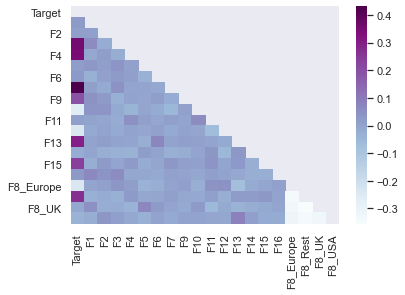

In [10]:
sns.set_theme()
# Compute the correlation matrix
corr_all = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, cmap = "BuPu")

Seems like the maybe the best columns to check will be:

- F3
- F4
- F7
- F9
- F13
- F15
- F8_Rest

This will help to reduce the complexity but have those variables that seems correlated with the class column

#### Creation of datasets

With this function we will prepare the df to have specific columns in the created training and testing datasets, as well as scaling the values of the inputs

In [11]:
corr_cols = ['F3', 'F4', 'F7', 'F9', 'F13', 'F15', 'F8_Rest']
def create_datasets(all_columns=True, cols=None):
    x_cols = df.columns[1:] if all_columns else corr_cols if cols is None else cols
    X, Y = df[x_cols], df['Target']
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    return (x_train, y_train), (x_test, y_test)

corr_datasets = lambda: create_datasets(False)

## Check the performance

#### Create function to permurate params
What this function will do is the following

1. Create all the combination of the possible parameters values given to the function.Ex.

`params = [[1, 2], [4, 5]] -> products = [(1, 4), (1, 5), (2, 4), (2, 5)]`

2. Evaluate each of the products using the builder function. _Note. All the builders will return a score, in this case the score is the mean accuracy of the model_
3. Based on the prior evaluation, we will see which is the argmax and return the score and params used

In [12]:
def permutate_params(builder, params):
    products = list(product(*params))
    scores = list(map(builder, products))
    max_index = np.argmax(scores)
    return scores[max_index], products[max_index]

This score function is to conveniently get the score for the scikit learn models

In [13]:
def get_score(model):
    return model.fit(training[0], training[1]).score(testing[0], testing[1])

#### Get training and testing datasets

In [31]:
training, testing = create_datasets()

### LinearRegressor

In [15]:
get_score(LinearRegression())

0.7710127762911145

### AdaBoostRegressor

In [16]:
def build_ada(values):
    n_estimators, learning_rate, loss = values
    return get_score(AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss=loss,
    ))

In [17]:
estimator_values = [25, 50, 100, 200]
learning_rate = [0.25, 0.5, 1, 2]
loss = ['linear', 'square', 'exponential']

In [18]:
permutate_params(build_ada, [estimator_values, learning_rate, loss])

(0.7180073854989814, (200, 1, 'square'))

### RandomForestRegressor

In [19]:
def build_forest(values):
    n_estimators, criterion, max_depth, max_features = values
    return get_score(RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        max_features=max_features
    ))

In [20]:
estimator_values = [25, 50, 100, 200]
criterions = ['mse', 'mae']
max_depth = [10, 40, 160, None]
max_features = ['auto', 'sqrt', 'log2']

In [21]:
permutate_params(build_forest, [estimator_values, criterions, max_depth, max_features])

(0.6824304533331697, (100, 'mse', 40, 'auto'))

### Neural Networks

This builder function is the must complicated of all. The overall objective of the builder is to create a function that creates a MLP Neural Network that consists of **3 hidden layers**.

The main difference with the other builders is that the parameters received for the builder are actually an array consisting of tuples of parameters. As each of this tuples are the parameters that each of the layers may have, in this case being the amount of units per layer and the activation function.

In [33]:
def build_nn(values):
    model = Sequential()
    for index, layer_params in enumerate(values):
        units, activation = layer_params
        if index == 0:
            model.add(Dense(units, activation=activation, input_shape=input_shape))
        else:
            model.add(Dense(units, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='Adam', loss='mse')
    model.fit(training[0], training[1], epochs=50, verbose=0)
    return r2_score(testing[1], model.predict(testing[0]), multioutput='variance_weighted')

In [23]:
layer_products = list(product([5, 10, 20, 50], ['tanh', 'relu', 'sigmoid']))

In [34]:
inputs_num = training[0].shape[1]
input_shape = (inputs_num,)
best_params, best_score = [], 0

for params in list(product(layer_products, layer_products, layer_products)):
    score = build_nn(params)
    if score > best_score:
        best_params = params
        best_score = score

print('Best params', best_params)
print('Best Score', best_score)

Best params ((20, 'tanh'), (50, 'relu'), (50, 'relu'))
Best Score 0.9716288287194671


## Check the performance (correlation features)

In [35]:
training, testing = corr_datasets()

After this we will reuse the same code for obtaining the best score and permutation as above, being the only difference the training and testing datasets used

In [26]:
get_score(LinearRegression())

0.6518751739405821

In [27]:
permutate_params(build_ada, [estimator_values, learning_rate, loss])

(0.571587543259356, (50, 2, 'square'))

In [28]:
permutate_params(build_forest, [estimator_values, criterions, max_depth, max_features])

(0.6628128381970622, (100, 'mse', 40, 'log2'))

In [36]:
best_params, best_score = [], 0
inputs_num = training[0].shape[1]
input_shape = (inputs_num,)

for params in list(product(layer_products, layer_products, layer_products)):
    score = build_nn(params)
    if score > best_score:
        best_params = params
        best_score = score

print('Best params', best_params)
print('Best Score', best_score)

Best params ((50, 'tanh'), (50, 'relu'), (50, 'relu'))
Best Score 0.7278559214049255


## Predict test dataset

Based on the results above, the best model that we obtained was the SVC model using all the data, the following scripts will be used to predict the class of the test dataset using the mentioned model

In [37]:
training, testing = create_datasets()

In [52]:
df = pd.read_csv('./CE802_P3_Data/CE802_P3_Test.csv')
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target
0,0.04,-0.21,3.68,1.54,-6.70,-929.34,234.18,USA,2,3391.35,-415.41,6,-1460.14,-20.55,Low,31369.98,NaN
1,0.89,2.97,2.28,1.97,-4.52,-700.62,106.84,Rest,2,3479.19,-320.73,2,-2301.76,-27.90,Low,29173.89,NaN
2,0.37,-0.17,7.14,0.40,-14.26,-796.14,32.30,USA,5,918.93,-379.44,4,-2589.08,-20.52,Very low,17248.26,NaN
3,5.37,0.07,7.18,6.81,-6.14,-801.03,32.92,Europe,2,2657.43,-491.28,6,-1767.44,-25.81,Low,15450.54,NaN
4,0.26,6.16,3.54,1.10,-16.76,-652.08,227.98,Rest,4,2739.96,-378.48,10,-1823.32,-23.11,Very low,35745.03,NaN


In [53]:
copy_df = df.copy()
preprocess()
df.head()

,Target,F1,F2,F3,F4,F5,F6,F7,F9,F10,F11,F12,F13,F14,F15,F16,F8_Europe,F8_Rest,F8_UK,F8_USA
0,NaN,0.04,-0.21,3.68,1.54,-6.70,-929.34,234.18,2,3391.35,-415.41,6,-1460.14,-20.55,1,31369.98,0,0,0,1
1,NaN,0.89,2.97,2.28,1.97,-4.52,-700.62,106.84,2,3479.19,-320.73,2,-2301.76,-27.90,1,29173.89,0,1,0,0
2,NaN,0.37,-0.17,7.14,0.40,-14.26,-796.14,32.30,5,918.93,-379.44,4,-2589.08,-20.52,0,17248.26,0,0,0,1
3,NaN,5.37,0.07,7.18,6.81,-6.14,-801.03,32.92,2,2657.43,-491.28,6,-1767.44,-25.81,1,15450.54,1,0,0,0
4,NaN,0.26,6.16,3.54,1.10,-16.76,-652.08,227.98,4,2739.96,-378.48,10,-1823.32,-23.11,0,35745.03,0,1,0,0


In [54]:
X = df.drop(columns=['Target'])
print(X.info())
X = MinMaxScaler().fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   F1         1500 non-null   float64
 1   F2         1500 non-null   float64
 2   F3         1500 non-null   float64
 3   F4         1500 non-null   float64
 4   F5         1500 non-null   float64
 5   F6         1500 non-null   float64
 6   F7         1500 non-null   float64
 7   F9         1500 non-null   int64  
 8   F10        1500 non-null   float64
 9   F11        1500 non-null   float64
 10  F12        1500 non-null   int64  
 11  F13        1500 non-null   float64
 12  F14        1500 non-null   float64
 13  F15        1500 non-null   int64  
 14  F16        1500 non-null   float64
 15  F8_Europe  1500 non-null   uint8  
 16  F8_Rest    1500 non-null   uint8  
 17  F8_UK      1500 non-null   uint8  
 18  F8_USA     1500 non-null   uint8  
dtypes: float64(12), int64(3), uint8(4)
memory usage:

In [55]:
inputs_num = training[0].shape[1]
input_shape = (inputs_num,)
model = Sequential([
    Dense(20, activation='tanh', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1, activation='linear'),
])
model.compile(optimizer='Adam', loss='mse')
model.fit(training[0], training[1], epochs=50, verbose=0)

In [56]:
copy_df['Target'] = model.predict(X)
copy_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target
0,0.04,-0.21,3.68,1.54,-6.70,-929.34,234.18,USA,2,3391.35,-415.41,6,-1460.14,-20.55,Low,31369.98,435.738495
1,0.89,2.97,2.28,1.97,-4.52,-700.62,106.84,Rest,2,3479.19,-320.73,2,-2301.76,-27.90,Low,29173.89,-53.704132
2,0.37,-0.17,7.14,0.40,-14.26,-796.14,32.30,USA,5,918.93,-379.44,4,-2589.08,-20.52,Very low,17248.26,72.795120
3,5.37,0.07,7.18,6.81,-6.14,-801.03,32.92,Europe,2,2657.43,-491.28,6,-1767.44,-25.81,Low,15450.54,148.129532
4,0.26,6.16,3.54,1.10,-16.76,-652.08,227.98,Rest,4,2739.96,-378.48,10,-1823.32,-23.11,Very low,35745.03,245.783798


In [57]:
copy_df.to_csv('./CE802_P3_Data/CE802_P3_Test.csv', index=False)